# Assignment 3 - Data Science in Finance and Insurance
Submission by: Dennis Goldenberg

In [284]:
#import statements
import numpy as np;
import pandas as pd;
import plotnine as pn;
import matplotlib as plt;

#set constants
A,B,c = 2.2e-4,2.7e-6,1.124

## Part [a] - Repeated Simpson's Rule for integration in Numpy

### Density function for future life Expectancy
As stated in the problem, I assume that mortality follows the Makeham law, or:
$$f_{T_x}(t) = (A + Bc^{x + t})e^{-At -\frac{B}{\log(c)}c^x(c^t - 1)}$$
Here, $x$ is the current age of the person, $t$ is the number of years they have left to live, and $A,B,c$ are constants, as defined above. I code this function below (and the Makeham function muliplied by T)

In [285]:
#Equation for probability density of living t more years given current age x
Makeham = lambda t,x,A = A,B = B,c = c : \
    (A + B*(c**(x + t)))*np.exp(-A*t - (B/np.log(c))*(c**x)*((c**t)- 1))

#Create version multiplied by t for purposes of expectation
multMakeham = lambda t,x,A = A,B = B,c = c : \
      t * (A + B*(c**(x + t)))* np.exp(-A*t - (B/np.log(c))*(c**x)*((c**t)- 1))


### Repeated Simpsons Rule Formula
I let $g_x(t) = tf_{T_x}(t)$. The expected future lifetime for a person of current age $x$ is (from the formula and assuming that no one lives past 130):
\begin{equation*}
\mathbb{E}[T_x] \approx \int_{0}^{130 - x}tf_{T_x}(t)dt = \int_{0}^{130 - x}g_x(t)dt
\end{equation*}
I can approximate this integral using the Simpson's rule:
\begin{equation*}
I_x = \int_{0}^{130 - x}g(t)dx \approx \frac{h}{3}\left(f(0, x) + 4\sum_{j = 1}^{n}f(0 + (2j - 1)h, x) + 2\sum_{j = 1}^{n - 1}f(0 + 2jh, x) + f(130 - x, x)\right)
\end{equation*}
Here, $h = \frac{b - a}{2n}$. This is coded below.

In [287]:
#Function for simpson's Method on Makeham, given the age
def Simpsons(func, currAge, a = 0, n = 50):
    #set upper bound of integration
    b = 130 - currAge;
    h = (b - a)/(2*n)
    
    #create arrays for function input for I
    input_1 = np.array([a + (2*j - 1)*h for j in range(1, n + 1)])
    input_2 = np.array([a + 2*j*h for j in range(1, n)])

    #Simpson's Rule approximation
    I = (h/3)*(func(a, currAge) + 4 * np.sum([func(t, currAge) for t in input_1]) +\
                2 * np.sum([func(t, currAge) for t in input_2]) + func(b, currAge))
    return I;

### Expected Age at Death, Creation of Data
Let the random variable representing age of death, given current age $x$, as $D_x$. Here, I note that Expected age of death is just the current age added to the expected future lifetime at that age, or:
\begin{equation*}
\mathbb{E}[D_x] \approx x + \mathbb{E}[T_x] = x + \int_{0}^{130 - x}g_x(t)dt
\end{equation*}

I code this below, and put it together into a dataframe.

In [288]:
#Create array of ages to evaluate
Ages = np.linspace(0, 100, 11);

#Create array for expected years left
Exp_Fut_life = np.array([Simpsons(multMakeham, age) for age in Ages]);

#Create arrau for expected death age
Exp_Death_date = Ages + Exp_Fut_life;

#put data together in 1 dataframe
data = pd.DataFrame(np.array([Ages, Exp_Fut_life, Exp_Death_date]).T, \
                    columns = ["current age", "expected future lifetime", "expected age at death"])

data

,current age,expected future lifetime,expected age at death
0,0.0,85.564247,85.564247
1,10.0,75.745777,85.745777
2,20.0,65.913131,85.913131
3,30.0,56.079203,86.079203
4,40.0,46.277622,86.277622
5,50.0,36.591443,86.591443
6,60.0,27.209687,87.209687
7,70.0,18.510407,88.510407
8,80.0,11.103323,91.103323
9,90.0,5.652803,95.652803


## Part [b] - Plotting Expected Future Life and Age of Death with Plotnine

### Create Layers for different aesthetics
I add two rows to specify the colors, as I want each aesthetic a different color. I then code the visualization by seperating it into layers.

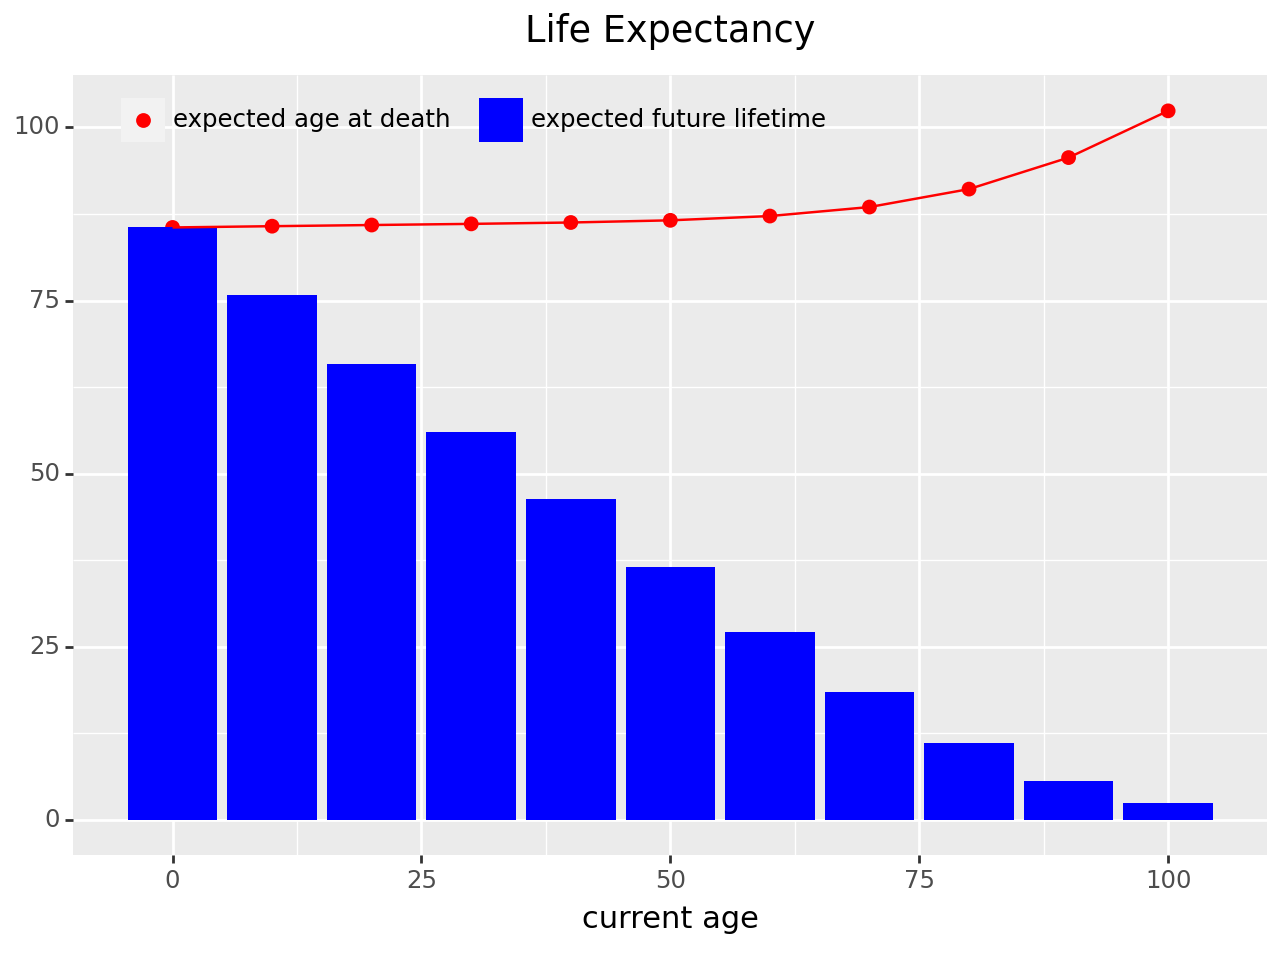

In [289]:
#add columns in dataframe to specify color
data2 = pd.DataFrame(data)
data2['color1'] = np.array(['red']*len(data2['current age']))
data2['color2'] = np.array(['blue']*len(data2['current age']))



#Create plot with layers
nplot = pn.ggplot(data2) +\
        pn.geom_point(mapping = pn.aes("current age", "expected age at death", color = "color1", name = 'A'), size = 2, stat = 'identity') +\
        pn.geom_bar(mapping = pn.aes("current age", "expected future lifetime", fill = "color2", name =  'B'), stat = 'identity') +\
        pn.geom_line(mapping = pn.aes("current age", "expected age at death"), color = 'red') +\
        pn.scale_color_manual(values = {'red': 'red'}, name = "", labels = ["expected age at death"]) +\
        pn.scale_fill_manual(values = {'blue': 'blue'}, name = "", labels = ['expected future lifetime']) +\
        pn.labs(title = "Life Expectancy") +\
        pn.theme(title = pn.element_text(hjust = 0.5), axis_title_y = pn.element_blank(), legend_title = pn.element_blank(), legend_box = 'horizontal', \
                 legend_position = (0.37,0.875), legend_background = pn.element_blank())

#show plot
print(nplot)